In [48]:
import pandas as pd
import numpy as np
import gspread
from pydata_google_auth import get_user_credentials
from google.cloud import bigquery
from pycaret.clustering import *

project_id = 'ledger-fcc1e'
creds = get_user_credentials([
    'https://www.googleapis.com/auth/cloud-platform', 
    'https://www.googleapis.com/auth/spreadsheets',
    'https://www.googleapis.com/auth/drive',
])
client = bigquery.Client(project=project_id, credentials=creds)

gc = gspread.authorize(creds) 
pull_data = lambda query: client.query(query).result().to_dataframe()
get_worksheet = lambda key, name: gc.open_by_key(key).worksheet(name)

In [49]:
query =\
'''
SELECT DISTINCT *
FROM (
  SELECT
    phone_number AS user_id,
    SPLIT(main_funding_bank, ',')[SAFE_ORDINAL(1)] AS main_funding_bank,
    customer_traffic_bucket
  FROM `ledger-fcc1e.temp_rachel.merchant_profiling_data_for_mse_prioritization_v2`
)
LEFT JOIN (
  SELECT
    phone_number_clean AS user_id,
    M0_core_count,
    M0_ppob_payment_count
  FROM `ledger-fcc1e.dg_buku_trnsfmd.EDC_BW_userbase_all`
) USING (user_id)
LEFT JOIN (
  SELECT
    user_id,
    acquisition_channel,
    -- user_segment_bucket,
    -- age_on_platform_days
  FROM `ledger-fcc1e.dg_buku_trnsfmd.user_profile_datamart`
) USING (user_id)

'''
raw = client.query(query).result().to_dataframe()
raw.to_pickle('data/raw_data.pkl')
raw = pd.read_pickle('data/raw_data.pkl')

In [50]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8032 entries, 0 to 8031
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   user_id                  8032 non-null   object
 1   main_funding_bank        6171 non-null   object
 2   customer_traffic_bucket  5992 non-null   object
 3   M0_core_count            7403 non-null   Int64 
 4   M0_ppob_payment_count    7403 non-null   Int64 
 5   acquisition_channel      7779 non-null   object
dtypes: Int64(2), object(4)
memory usage: 392.3+ KB


In [51]:
# df = raw

df =\
(
    raw
    .assign(
        M0_core_count = lambda x: np.log1p(x.M0_core_count.fillna(0)),
        M0_ppob_payment_count = lambda x: np.log1p(x.M0_ppob_payment_count.fillna(0))
    )
)

# tpv_col = df.filter(regex='TPV|tpv').columns
# for i in tpv_col:
#     df[i] = pd.to_numeric(df[i])

# # normalize the numeric columns
# num_col = [col for col in df.select_dtypes(include=['float', 'int']).columns if '_flag' not in col]
# num_col = [col for col in df[num_col].columns if 'age' not in col]
# for i in num_col:
#     df[i] = df[i].fillna(0).apply(np.log1p)

# # turn object columns to dummy
# # df = pd.get_dummies(data=df, columns=['acquisition_channel', 'kyc_tier', 'loyalty_tier'], prefix=['pm_acq', 'pm_kyc', 'pm_lyl'], dtype=bool)

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8032 entries, 0 to 8031
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   user_id                  8032 non-null   object 
 1   main_funding_bank        6171 non-null   object 
 2   customer_traffic_bucket  5992 non-null   object 
 3   M0_core_count            8032 non-null   Float64
 4   M0_ppob_payment_count    8032 non-null   Float64
 5   acquisition_channel      7779 non-null   object 
dtypes: Float64(2), object(4)
memory usage: 392.3+ KB


In [53]:
s = setup(
    df, 
    normalize=True, 
    ignore_features=['user_id'],
    use_gpu = True,
    session_id = 123)

,Description,Value
0,Session id,123
1,Original data shape,"(8032, 6)"
2,Transformed data shape,"(8032, 16)"
3,Ignore features,1
4,Numeric features,2
5,Categorical features,3
6,Rows with missing values,27.4%
7,Preprocess,True
8,Imputation type,simple
9,Numeric imputation,mean


In [54]:
kmeans = create_model('kmeans', num_clusters=4)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4057,1025.3104,1.2633,0,0,0


In [55]:
plot_model(kmeans, 'cluster')

In [56]:
plot_model(kmeans, 'tsne')

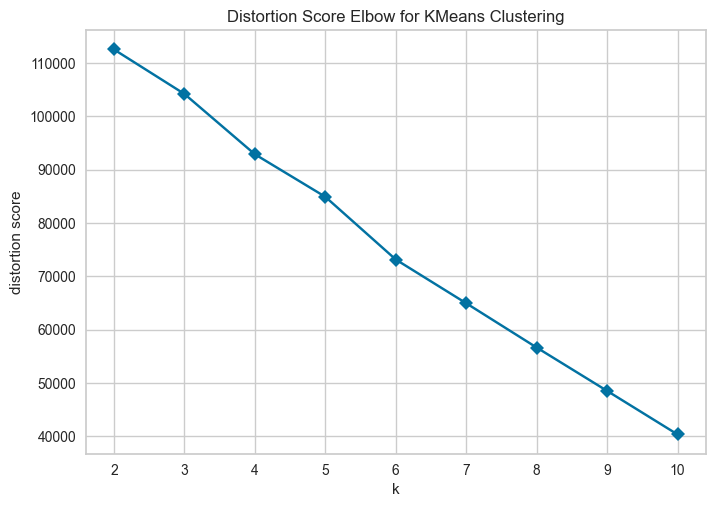

In [57]:
plot_model(kmeans, 'elbow')